# Pre-Processing TNG

Here I generate the `gal_fname1` which cointains the columns needed to this study: `Mr, R, R/R200, v_los, v_circ, orbital, infall, interloper`.


In [1]:
%cd ../

/Users/jesteves/Documents/GitHub/galaxyFormation


In [2]:
import sys
sys.path.append('./scripts')
from file_loc import FileLocs

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io.fits import getdata
import astropy.table as Table
import astropy.io.ascii as at

# Reading Initial Data

In [4]:
fl = FileLocs(dataset='tng')

cat = fl.load_catalogs('cluster/raw',is_hdf=True)
gal = fl.load_catalogs('galaxy/raw',is_hdf=True)

Loading Catalog: ./data/catalogs/TNG/TNG300-1_GalEvol_z0p10.hdf5
Loading Catalog: ./data/catalogs/TNG/TNG300-1_GalEvol_z0p10.hdf5


In [5]:
cat

HaloID,M200c,R200c,M200m,R200m
int64,float32,float32,float32,float32
0,15.138044,2269.8381,15.26395,3474.4258
1,15.05978,2137.5796,15.192753,3289.5754
2,14.993893,2032.1763,15.1044235,3073.9197
3,14.826947,1787.6604,15.001088,2839.546
4,14.617113,1521.7881,14.75004,2341.9282
5,14.865218,1841.0315,15.012252,2864.049
6,14.616884,1521.5239,14.728867,2304.209
7,14.765941,1705.9474,14.914375,2656.7302
8,14.768657,1709.5039,14.904154,2636.0461


In [6]:
# gal

In [7]:
# gal['R']

# Task to perform

1. Create New Variables
2. Create Masks
3. Assign Dynamical Classification

In [8]:
cat.rename_column('HaloID','Yang')
gal.rename_column('HostHaloID','Yang')

## New Variables

In this section we compute the distance from the center and the phase space normalized variables (`R/R_200`, `v_los/v_circ`). Also, we assign k-correction and absolute magnitudes.


In [9]:
cid  = np.array(cat['Yang'])
r200m = np.array(cat['R200m'])
r200c = np.array(cat['R200c'])
m200c = np.array(cat['M200c'])
m200m = np.array(cat['M200m'])
zcls = 0.1*np.ones_like(r200m)

In [10]:
# compute vcircm
from astropy.cosmology import Planck13
from astropy import units as u
from astropy.constants import G, c

def vcirc(mass,redshift,mdef,cosmo):
    '''Calculate circular velocity in km/s for halos of mass M (Msun/h)'''
    rho_crit = cosmo.critical_density(redshift)
    if mdef[-1] == 'c':
        delta = int(mdef[:-1])
        rho = delta*rho_crit
    elif mdef[-1] == 'm':
        delta = int(mdef[:-1])
        rho = delta*rho_crit*cosmo.Om(redshift)
    else:
        raise RuntimeError("Not correct mass definition")
    v = np.sqrt(G*(np.pi*4*rho/3)**(1./3)*(mass*u.Msun/cosmo.h)**(2./3))
    a = v.to(u.km/u.s)
    return a.value

In [11]:
vcirc_m   = vcirc((10**m200m)*Planck13.h,zcls,'200m',Planck13)

In [12]:
import esutil
gcid = np.array(gal['Yang'])
cid  = np.array(cat['Yang'])

key = esutil.numpy_util.match(cid,gcid)

In [13]:
into_cls, into_gal = key[0], key[1]

### Assigning new variables

In [14]:
gal.columns

<TableColumns names=('SubhaloID','Mstar','Yang','R_proj','v_los','V200c_host','V200m_host','t_infall','Mstar_bulge','S_over_T','SFR','Stellar_age')>

In [15]:
gal.rename_column('R_proj','R')
gal.rename_column('S_over_T','BT')
gal.rename_column('Mstar','mass')
gal.rename_column('v_los','vlos')

In [16]:
#columns = ['Yang','ra','dec','distance','mr_petro','mg','mr','mass','z','zErr','bpt','ssfr','sfr']
data = gal[into_gal].copy()

data['Yang'] = cid[into_cls]
data['R200m'] = r200m[into_cls]
data['R200c'] = r200c[into_cls]
data['M200c'] = m200c[into_cls]
data['redshift'] = zcls[into_cls]

In [17]:
Rproj = np.array(gal['R'][into_gal])
data['Rm'] = Rproj
data['R']  = Rproj*data['R200m']
data['Rc'] = data['R']/data['R200c']


In [18]:
nzero = data['SFR']>=1e-10
data['log_sfr'] = -11.
data['log_sfr'][nzero] = np.log10(data['SFR'])[nzero]
data['ssfr'] = data['log_sfr']-data['mass']
data['ssfr'][~nzero] = -12.5

<ipython-input-18-071240b53b9e>:3: RuntimeWarning: divide by zero encountered in log10
  data['log_sfr'][nzero] = np.log10(data['SFR'])[nzero]


In [19]:
star_forming = (data['ssfr']>-11.0)
quenching    = np.logical_not(star_forming)

In [20]:
data['SF'] = np.array(star_forming).astype(int)

In [21]:
from astropy.constants import G, c
def get_los_velocity(z_gal,z_BCG,c_kms = c.value/1000):
    return np.array(c_kms*(z_gal - z_BCG)/(1 + z_BCG))

In [22]:
vlos = data['vlos']
data['vlosn'] = data['vlos']/vcirc_m[into_cls]

## Ploting Distributions

### Radial Distribution

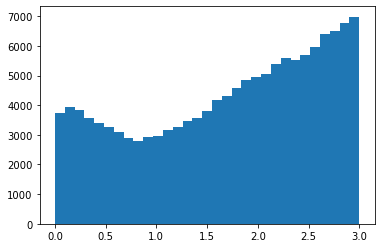

In [23]:
_ = plt.hist(data['Rm'],bins=31)
# _ = plt.hist(data['Rc'],bins=31)

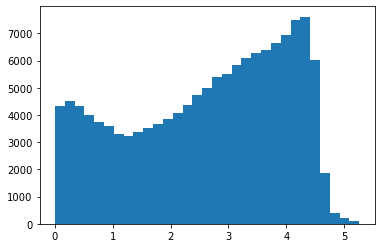

In [24]:
_ = plt.hist(data['Rc'],bins=31)

### Line of Sight Velocity

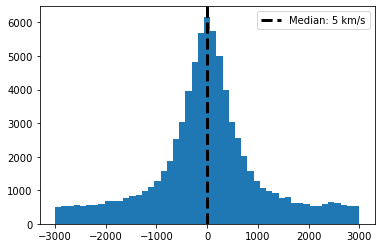

In [25]:
vmask = np.abs(vlos)<=3000.
zm = np.median(vlos[vmask])
_ = plt.hist(vlos,bins=np.linspace(-3000.,3000.))
plt.axvline(zm,ls='--',lw=3,color='k',label='Median: %i km/s'%zm)
plt.legend()

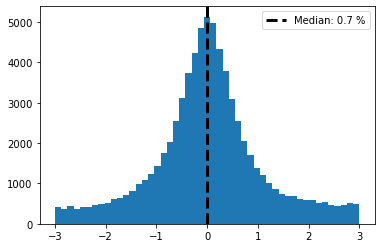

In [26]:
vm_mask = np.abs(data['vlosn'])<=3.
zm = np.median(data['vlosn'][vmask])
_ = plt.hist(data['vlosn'],bins=np.linspace(-3.,3.))
plt.axvline(zm,ls='--',lw=3,color='k',label='Median: %.1f %%'%(zm*100))
plt.legend()

In [27]:
## inital l.o.s velocity cut of 10.000 km/s
velocity_mask = (np.abs(data['vlos'])<10*1e3)

vlos_mask = (np.abs(data['vlosn'])<3.0)

In [28]:
print(f'Total of good galaxies: {np.count_nonzero(velocity_mask)}')
print(f'Galaxies within vlos/vcirc < 3: {np.count_nonzero(vlos_mask)}')

Total of good galaxies: 135268
Galaxies within vlos/vcirc < 3: 73145


## Create Masks

I use a volume limited and a magnitude threshold sample.

## Assign Dynamical Classification

Assign probability for three dynamical classes: `interloper`, `orbital`, `infall`.


In [29]:
from sklearn.ensemble import RandomForestClassifier
import joblib
loaded_rf = joblib.load("/Users/jesteves/Downloads/phase_space/classification_2d_rf.joblib")

/usr/local/anaconda/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/usr/local/anaconda/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [30]:
rnorm_c = np.array(data['Rc'])
rnorm_m = np.array(data['Rm'])

vlosn_c = np.array(data['vlos'])
vlosn_m = np.array(data['vlosn'])

In [31]:
import pandas as pd
df2   = pd.DataFrame ({ 'r2d':rnorm_m, 'vlos':vlosn_m})
tags2 = loaded_rf.predict(df2) 
tag_probability2 = loaded_rf.predict_proba(df2) 

### Plot Distributions

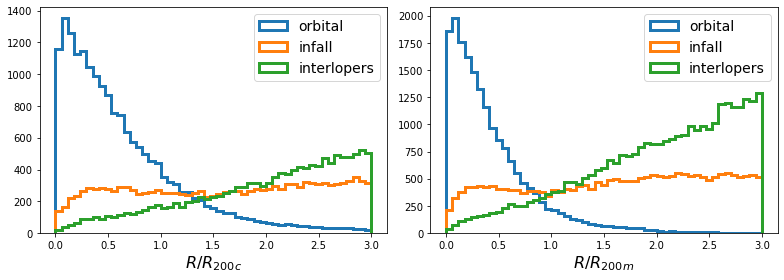

In [32]:
fig = plt.figure(figsize=(11,4))
plt.subplot(1, 2, 1)
cut = (np.abs(vlosn_m)<3.)&(rnorm_c<3.)
labels = ['orbital','infall','interlopers']
for i in range(3):
    plt.hist(rnorm_c[cut],bins=51,weights=tag_probability2[cut,i],histtype='step', lw=3, label=labels[i],density=False)

plt.legend(fontsize=14)
plt.xlabel(r'$R/R_{200c}$',fontsize=16)
# plt.title('Normalized by: Vcir(M200c), R200c',fontsize=16)
# plt.ylim(-0.025,1.5)

plt.subplot(1, 2, 2)
cut2 = (np.abs(vlosn_m)<3.)&(rnorm_m<3.)
labels = ['orbital','infall','interlopers']
for i in range(3):
    plt.hist(rnorm_m[cut2],bins=51,weights=tag_probability2[cut2,i],histtype='step', lw=3, label=labels[i],density=False)

plt.legend(fontsize=14)
plt.xlabel(r'$R/R_{200m}$',fontsize=16)
# plt.title('Normalized by: Vcir(M200m), R200m',fontsize=16)
# plt.ylim(-0.025,1.5)
plt.tight_layout()
# plt.savefig('./plots/radial_distribtution_prob_weighted.png',dpi=100,facecolor='w',transparent=False)


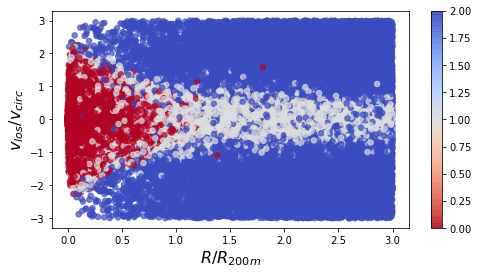

In [33]:
cut = (np.abs(vlosn_m)<3.)&(rnorm_m<3.)
plt.figure(figsize=(8,4))
plt.scatter(rnorm_m[cut],vlosn_m[cut],c=tags2[cut],alpha=0.7,s=30,cmap='coolwarm_r')
plt.xlabel(r'$R/R_{200m}$',fontsize=16)
plt.ylabel(r'$v_{los}/ v_{circ} $',fontsize=16)
plt.colorbar()


In [34]:
data['VLOS_MASK'] = np.where(vlos_mask,1,0)

for i,li in enumerate(labels):
    data[li] = tags2 == i
    data['p_%s'%li] = tag_probability2[:,i]

In [35]:
# a = plt.hist(data['Rm'][cut2],weights=data['p_orbital'][cut2],histtype='step',lw=3,bins=31)
# _ = plt.hist(data['Rm'][cut2],weights=data['p_infall'][cut2],histtype='step',lw=3,bins=a[1])
# _ = plt.hist(data['Rm'][cut2],weights=data['p_interlopers'][cut2],histtype='step',lw=3,bins=a[1])

# Save Output Samples

In [36]:
len(data)

136515

In [37]:
data[velocity_mask]

SubhaloID,mass,Yang,R,vlos,V200c_host,V200m_host,t_infall,Mstar_bulge,BT,SFR,Stellar_age,R200m,R200c,M200c,redshift,Rm,Rc,log_sfr,ssfr,SF,vlosn,VLOS_MASK,orbital,p_orbital,infall,p_infall,interlopers,p_interlopers
int32,float32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float64,float64,float64,float64,int64,float64,int64,bool,float64,bool,float64,bool,float64
0,12.807409,0,0.0,97.26800537109375,1613.8382414808939,1507.887434577236,--,12.549362814638968,0.6643368435642611,0.0,10.126032957962474,3474.4258,2269.8381,15.138044,0.1,0.0,0.0,-11.0,-12.5,0,0.06454647350085066,1,True,0.77,False,0.23,False,0.0
1,12.550011,0,6058.62045136363,-59.31558965455139,1613.8382414808939,1507.887434577236,--,12.262298893113561,0.6890437069227345,0.20968544483184814,9.445555743605391,3474.4258,2269.8381,15.138044,0.1,1.743776046119457,2.66918612326038,-0.678431714735411,-13.228442395887754,0,-0.039361474733834986,1,False,0.15,True,0.71,False,0.14
2,11.965729,0,977.6733826689368,1648.6933739463502,1613.8382414808939,1507.887434577236,0.13692906918792058,11.763254646769985,0.8388035594202955,0.0,10.046613865860719,3474.4258,2269.8381,15.138044,0.1,0.2813913562192132,0.4307238334287162,-11.0,-12.5,0,1.0940631790120106,1,True,0.51,False,0.47,False,0.02
3,11.53819,0,4150.0231009922745,-109.959971106864,1613.8382414808939,1507.887434577236,--,11.306994501429326,0.7547409297760412,0.0,9.81646366935296,3474.4258,2269.8381,15.138044,0.1,1.1944486261264196,1.8283343809539045,-11.0,-12.5,0,-0.07296878695235129,1,False,0.28,False,0.3,True,0.42
4,11.546501,0,3603.6621139347526,151.26342604219357,1613.8382414808939,1507.887434577236,2.200451156828324,11.401548191180332,0.895530789047599,0.0,9.618550818848373,3474.4258,2269.8381,15.138044,0.1,1.0371964580110435,1.5876295576939248,-11.0,-12.5,0,0.10037751553998524,1,False,0.26,True,0.57,False,0.17
5,11.926732,0,222.6713786321414,92.44753952632745,1613.8382414808939,1507.887434577236,4.298360295288629,11.750875885781408,0.7938871210381263,0.0,10.790838002650544,3474.4258,2269.8381,15.138044,0.1,0.06408868476448806,0.09810011349339393,-11.0,-12.5,0,0.06134764085568746,1,True,0.94,False,0.06,False,0.0
6,11.491526,0,5653.197353155178,450.020737646827,1613.8382414808939,1507.887434577236,--,11.24269424126622,0.6841681363692542,0.0,9.549768351791249,3474.4258,2269.8381,15.138044,0.1,1.6270882468300467,2.4905729032255004,-11.0,-12.5,0,0.2986311018359434,1,False,0.02,True,0.67,False,0.31
7,11.130512,0,8976.968563827506,-331.82147460681745,1613.8382414808939,1507.887434577236,--,10.90956417512482,0.7623381190403846,0.0,8.226407972734629,3474.4258,2269.8381,15.138044,0.1,2.5837272484772567,3.9548937108479914,-11.0,-12.5,0,-0.22019476945177632,1,False,0.0,True,0.9,False,0.1
8,11.259239,0,5993.0498228327015,-250.83137520139576,1613.8382414808939,1507.887434577236,--,10.880579484536176,0.49737504493197604,0.0,8.486857065873485,3474.4258,2269.8381,15.138044,0.1,1.7249036819766437,2.640298323938205,-11.0,-12.5,0,-0.16645021814573233,1,False,0.02,True,0.94,False,0.04


In [39]:
data['VOLUME_LIM_MASK'] = np.where(data['mass']>9.,1,0)
data['MAG_TH_MASK'] = np.where(data['mass']>10.05,1,0)

In [40]:
print(f'Saving file: {fl.galaxy}')
print(f'Number of Galaxies: {len(data[velocity_mask])}')
data[velocity_mask].write(fl.galaxy,format='csv',overwrite=True)

Saving file: ./data/catalogs/TNG/TNG300-1_GalEvol_z0p00_pp.csv
Number of Galaxies: 135268


In [41]:
print(f'Saving file: {fl.cluster}')
print(f'Number of Clusters: {len(cat)}')
cat.write(fl.cluster,format='csv',overwrite=True)

Saving file: ./data/catalogs/TNG/TNG300-1_GalEvol_z0p10.csv
Number of Clusters: 250


In [ ]:
# To Do: run cluster_fraction [done]
# To Do: run runComputeFractions